../../images/dl_roboflow_dataset/train/fractured
253_jpg.rf.08841915981ed1756a556a3cd9ae7b33.jpg


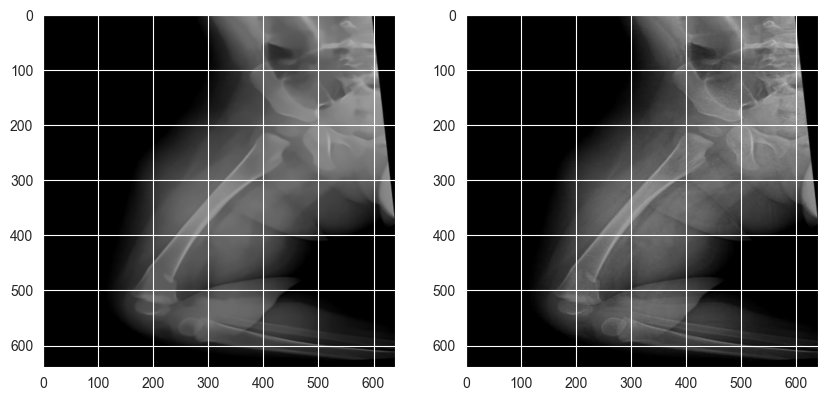

../../images/dl_roboflow_dataset/train/non-fractured
196_jpg.rf.5c1a2c10cb8bc115c3bc510b4b6b0e68.jpg


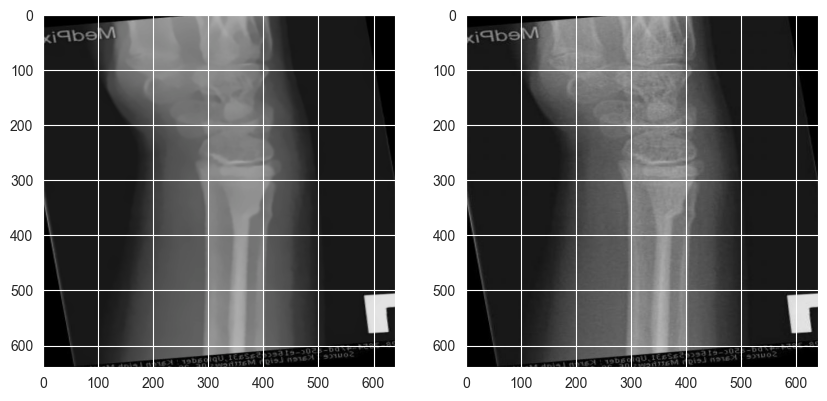

In [1]:
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Train and test dataset path.
train_dataset = "../../images/dl_roboflow_dataset/train"
test_dataset = "../../images/dl_roboflow_dataset/test"

# Categorized images
categories = ["fractured", "non-fractured"]

# Reading original image from directory
for category in categories:
    label = categories.index(category)
    path = os.path.join(train_dataset, category)
    print(path)
    for img_file in os.listdir(path):
        print(img_file)
        img = cv.imread(os.path.join(path, img_file), 1)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        dst = cv.fastNlMeansDenoisingColored(img, None, 5, 10, 7, 21)

        plt.figure(figsize=(10, 8))
        plt.subplot(121)
        plt.imshow(dst)
        plt.subplot(122)
        plt.imshow(img)
        plt.show()
        break


In [2]:
# Make train data
train_data = []

for category in categories:
    # Each category into unique integer
    label = categories.index(category)
    path = os.path.join(train_dataset, category)

    for img_file in os.listdir(path):
        img = cv.imread(os.path.join(path, img_file), 1)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (60, 60))
        train_data.append([img, label])

# Make test data
test_data = []

for category in categories:
    #each category into unique integer
    label = categories.index(category)
    path = os.path.join(test_dataset, category)

    for img_file in os.listdir(path):
        img = cv.imread(os.path.join(path, img_file), 1)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (60, 60))
        test_data.append([img, label])

# Print total data in train and test
print("Total Train Data: " + str(len(train_data)))
print("Total Test Data: " + str(len(test_data)))

Total Train Data: 801
Total Test Data: 200


/Users/kosrat/projects/ml/fracture-detection/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

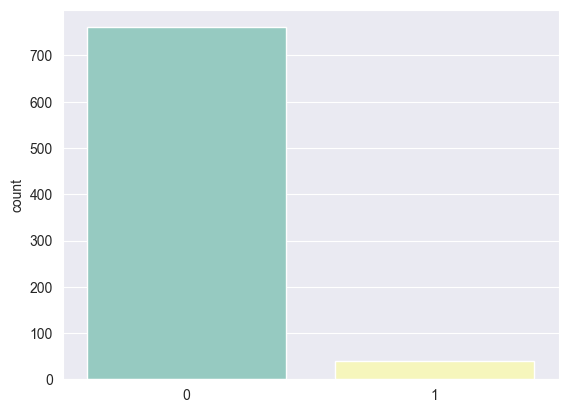

In [3]:
import random

# Shuffle the dataset fo good result
random.shuffle(train_data)
random.shuffle(test_data)

# Let's separate the feature and target variable for Train dataset
train_x = []
train_y = []
for features, label in train_data:
    train_x.append(features)
    train_y.append(label)

# Let's separate the feature and target variable for Test dataset
test_x = []
test_y = []
for features, label in test_data:
    test_x.append(features)
    test_y.append(label)

# Convert image array to numpy array
# -1 means same size
# 60*60 means height and width
# 3 for R+G+B
train_x = np.array(train_x).reshape(-1, 60, 60, 3)
train_x = train_x / 255.0
# We divide the np array by 255 to close all values to 0

# Convert image array to numpy array
# -1 means same size
# 60*60 means height and width
# 3 for R+G+B
test_x = np.array(test_x).reshape(-1, 60, 60, 3)
test_x = test_x / 255.0
#we divide the np array by 255 to close all values to 0

# Count labels
sns.countplot(train_y, palette='Set3')


In [4]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, AveragePooling2D, \
    MaxPooling2D, Dropout, Activation

# Train y
one_hot_train = to_categorical(train_y)
# Test y
one_hot_test = to_categorical(test_y)

# Build the models

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 64)        0

2023-08-26 22:24:41.763792: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# We will choose adam optimizer
# We have 2 categories so loss function is categorical_crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

# Let's split the 20% train dataset for validation
hist = model.fit(train_x, one_hot_train, epochs=100, batch_size=32,
                 validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 3s 102ms/step - loss: 0.3004 - accuracy: 0.9000 - val_loss: 0.2720 - val_accuracy: 0.9627
Epoch 2/100
20/20 [==============================] - 2s 90ms/step - loss: 0.2252 - accuracy: 0.9469 - val_loss: 0.2116 - val_accuracy: 0.9627
Epoch 3/100
20/20 [==============================] - 2s 93ms/step - loss: 0.2162 - accuracy: 0.9469 - val_loss: 0.2585 - val_accuracy: 0.9627
Epoch 4/100
20/20 [==============================] - 2s 92ms/step - loss: 0.2113 - accuracy: 0.9469 - val_loss: 0.2358 - val_accuracy: 0.9627
Epoch 5/100
20/20 [==============================] - 2s 96ms/step - loss: 0.2189 - accuracy: 0.9469 - val_loss: 0.2992 - val_accuracy: 0.9627
Epoch 6/100
20/20 [==============================] - 2s 94ms/step - loss: 0.2159 - accuracy: 0.9469 - val_loss: 0.2149 - val_accuracy: 0.9627
Epoch 7/100
20/20 [==============================] - 2s 94ms/step - loss: 0.2118 - accuracy: 0.9469 - val_loss: 0.2209 - val_accuracy: 0.9627
Epoch

7/7 [==============================] - 0s 14ms/step - loss: 0.3571 - accuracy: 0.9600


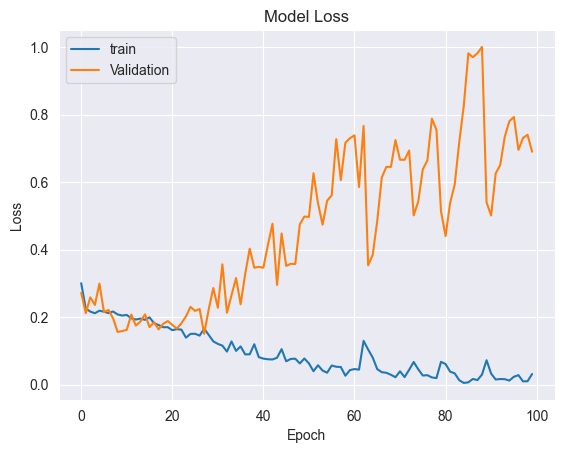

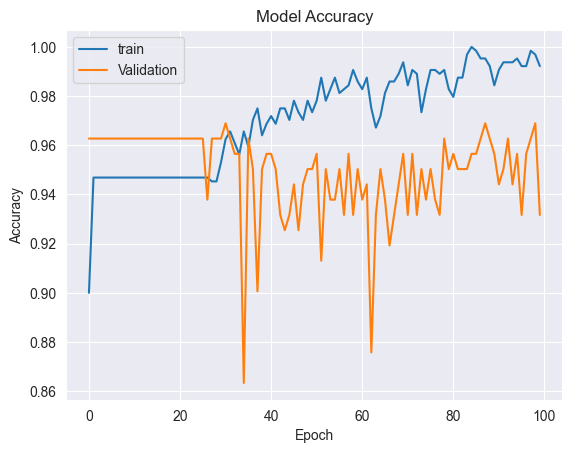

In [6]:
# Model evaluation
test_loss, test_acc = model.evaluate(test_x, one_hot_test)

# Train and validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

# Train and validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
